In [1]:
import glob
import h5py as h5
import numpy as np
from matplotlib import pyplot as plt
import sys
import pickle as pkl
import time
from scipy import linalg as LA
from scipy import optimize as op
from functools import partial
from numba import jit
import multiprocessing as mp
from itertools import product
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
'''
Helper function to compute exact infection probabilities
 for integer viral load
We use numba to accelerate these calculations

Variables are defined as follows:
	num_vir: non-negative int, number of viruses in the environment
			 attempting to infect cells
	num_cells: non-negative int, number of cells in pool
	e: 1-D numpy array of length M+1 with real-valued components in [0,1]
		the replicative fitnesses of viruses in the current simulation
	prob_vec: 1-D numpy array of length M+1 with real-valued 
				components in [0,1] whose (L-1) sum is 1
			  the match-number distribution of viruses in the environment
	psi_r: 1-D numpy array of length M+1 with real-valued 
				components in [0,1] whose (L-1) sum is <= 1
			  the match-number distribution of viruses in cells
'''
@jit("float64[:](int64, int64, float64[:], float64[:], float64[:])", nopython=True, cache=True)
def lambda_int(num_vir,num_cells, e, prob_vec, psi_r):
    psi_lambda = psi_r
    if num_vir != 0:
        for i in range(num_vir):
            psi_lambda = psi_lambda + (1.0 / num_cells) * prob_vec * (
                1 - np.power(1 - e * (1 - np.sum(psi_lambda)), num_cells))
    return psi_lambda


'''
Function to compute interpolated infection probabilities
We use numba to accelerate these calculations

Variables are defined as follows:
	num_vir: non-negative real, number of viruses in the environment
			 attempting to infect cells
	num_cells: non-negative int, number of cells in pool
	e: 1-D numpy array of length M+1 with real-valued components in [0,1]
		the replicative fitnesses of viruses in the current simulation
	prob_vec: 1-D numpy array of length M+1 with real-valued 
				components in [0,1] whose (L-1) sum is 1
			  the match-number distribution of viruses in the environment
	psi_r: 1-D numpy array of length M+1 with real-valued 
				components in [0,1] whose (L-1) sum is <= 1
			  the match-number distribution of viruses in cells
'''
@jit("UniTuple(float64[:], 2)(int64, int64, float64[:], float64[:], float64[:])", nopython=True, cache=True)
def calc_lambda(num_vir, num_cells, e, prob_vec, psi_r):
    inv = int(num_vir)
    return (num_vir-inv)*lambda_int(1+inv,num_cells, e, prob_vec, psi_r), (
        1-num_vir+inv)*lambda_int(inv,num_cells, e, prob_vec, psi_r)

In [5]:
# mutation matrix calculation
M = 50
w = 0.7867
mut_mat = np.zeros((M+1,M+1))
for i in range(0,M):
    # one fewer match
    mut_mat[i][i+1] = (w/100.0)*((i+1)*1.0/(1.0 + np.exp(-(1.0*(i+1)-10)/2)))
    # one more match
    mut_mat[i+1][i] = (w/235.45)*(np.exp(4.709*(1.0-1.0*i/50.0))-1)
    # same number of matches
for i in range(1,M):
    mut_mat[i][i] = 1.0 - mut_mat[i+1][i] - mut_mat[i-1][i]
mut_mat[0][0] = 1.0 - mut_mat[1][0]
mut_mat[M][M] = 1.0 - mut_mat[M-1][M]

difference between 49 after infection and 49 before infection
[0.0142338850295856, 0.011568947451213993, 0.00917248413146346, 0.007047210858032893, 0.005195881998268426, 0.0036212912295101596, 0.002326272286808484, 0.0013136997285314589, 0.000586489720349137, 0.00014760083815146263, 0.0]
ratio of difference between 49 after infection and 49 before infection to 50 after
[0.014439413988188057, 0.013021772953595308, 0.011598590017937933, 0.010169828260246908, 0.008735450614774157, 0.007295420140964452, 0.0058497007086327525, 0.004398259067581843, 0.0029410731475849536, 0.0014781902026432007, nan]


<ipython-input-14-47c1cda8288d>:20: RuntimeWarning: invalid value encountered in double_scalars
  print([(_[0][-2] - _[1])/_[0][-1] for _ in zip(tpf, fills)])
<ipython-input-14-47c1cda8288d>:25: RuntimeWarning: invalid value encountered in double_scalars
  [(_[0][-2] - _[1])/_[0][-1] for _ in zip(tpf, fills)][:-1],


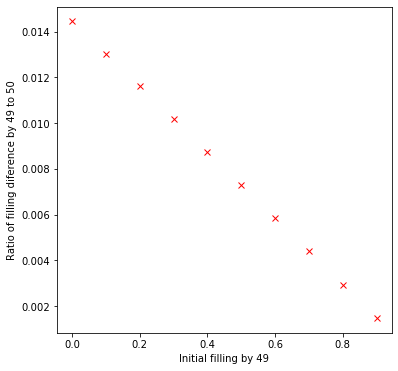

<ipython-input-14-47c1cda8288d>:33: RuntimeWarning: invalid value encountered in double_scalars
  b1_from49 = np.array([(_[0][-2] - _[1])/(1 - _[1])/(1 - _[1]) for _ in zip(tpf, fills)][:-1])
<ipython-input-14-47c1cda8288d>:34: RuntimeWarning: invalid value encountered in double_scalars
  b1_from50 = np.array([(1 - _[1] - _[0][-1]) /(1 - _[1])/(1 - _[1]) for _ in zip(tpf, fills)][:-1])


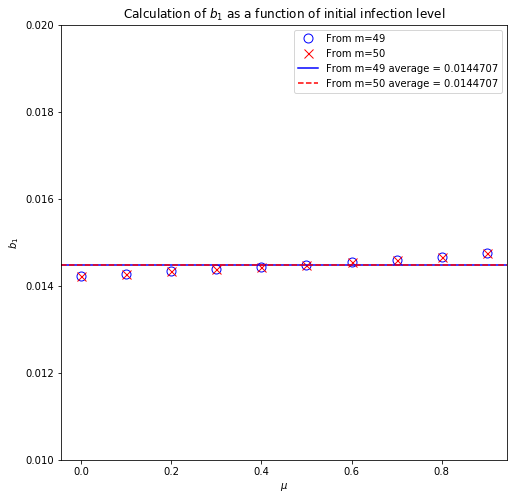

0.0142338850295856 0.014233885029585558 0.014233885029585558
0.01447069683704764
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [14]:
# T=0.1

pvf_inp = np.zeros(51)
pvf_inp[-1] = mut_mat[-1, -1]
pvf_inp[-2] = mut_mat[-2, -1]

fills = 1e-1*np.arange(0,11)
pvf = np.zeros(51)
pvf[-1] = 0.6
pvf[-2] = 0.4
# pvf = np.ones(51)/51
prf = [np.zeros(51) for _ in range(len(fills))]
for a,b in zip(prf, fills):
    a[-2] = b
tpf = [calc_lambda(num_vir=2000, num_cells=1000, e=np.exp(-(50-np.arange(51))/0.1),
            prob_vec=pvf_inp, psi_r=_)[1][48:] for _ in prf]
print('difference between 49 after infection and 49 before infection')
print([(_[0][-2] - _[1]) for _ in zip(tpf, fills)])
print('ratio of difference between 49 after infection and 49 before infection to 50 after')
print([(_[0][-2] - _[1])/_[0][-1] for _ in zip(tpf, fills)])

plt.close()
plt.figure(figsize=(6,6))
plt.plot(np.arange(0,10)/10., 
         [(_[0][-2] - _[1])/_[0][-1] for _ in zip(tpf, fills)][:-1],
        'rx')
plt.xlabel('Initial filling by 49')
plt.ylabel('Ratio of filling diference by 49 to 50')
plt.show()
plt.close()


b1_from49 = np.array([(_[0][-2] - _[1])/(1 - _[1])/(1 - _[1]) for _ in zip(tpf, fills)][:-1])
b1_from50 = np.array([(1 - _[1] - _[0][-1]) /(1 - _[1])/(1 - _[1]) for _ in zip(tpf, fills)][:-1])

plt.close()
plt.figure(figsize=(8,8))
plt.plot(fills[:-1],
         b1_from49,
        'bo', ms=9, mfc='none', label='From m=49')
plt.plot(fills[:-1],
         b1_from50,
        'rx', ms=9, label='From m=50')
plt.axhline(np.mean(b1_from49), c='b', ls='-', label='From m=49 average = {:.07f}'.format(np.mean(b1_from49)))
plt.axhline(np.mean(b1_from50), c='r', ls='--', label='From m=50 average = {:.07f}'.format(np.mean(b1_from50)))
plt.legend()
plt.title(r'Calculation of $b_{1}$ as a function of initial infection level')
plt.ylabel(r'$b_{1}$')
plt.xlabel(r'$\mu$')
plt.ylim([0.01, 0.02])
plt.show()
plt.close()

print(b1_from49[0], b1_from50[0], 1.0 - tpf[0][-1])
print(np.mean(b1_from49))
print([np.sum(_) for _ in tpf])

In [15]:
gamma = 0.0142338850295856
b = -(2 + np.linspace(0,1,50) / (1 - np.linspace(0,1,50)) / gamma)
root_plus = (-b + np.sqrt(b ** 2 - 4)) / 2
root_minus = (-b - np.sqrt(b ** 2 - 4)) / 2
print(root_plus, root_minus)

[1.00000000e+00 3.14575477e+00 4.78038138e+00 6.42622825e+00
 8.12175281e+00 9.88231919e+00 1.17176664e+01 1.36358117e+01
 1.56443500e+01 1.77510150e+01 1.99639837e+01 2.22920823e+01
 2.47449568e+01 2.73332352e+01 3.00686981e+01 3.29644679e+01
 3.60352254e+01 3.92974624e+01 4.27697798e+01 4.64732447e+01
 5.04318182e+01 5.46728755e+01 5.92278397e+01 6.41329623e+01
 6.94302896e+01 7.51688717e+01 8.14062851e+01 8.82105716e+01
 9.56627307e+01 1.03859959e+02 1.12919915e+02 1.22986399e+02
 1.34237046e+02 1.46893899e+02 1.61238211e+02 1.77631591e+02
 1.96546910e+02 2.18614664e+02 2.44694618e+02 2.75990440e+02
 3.14240765e+02 3.62053539e+02 4.23526967e+02 5.05491386e+02
 6.20241403e+02 7.92366229e+02 1.07924069e+03 1.65298927e+03
 3.37423433e+03            inf] [1.00000000e+00 3.17888734e-01 2.09188331e-01 1.55612275e-01
 1.23126131e-01 1.01190822e-01 8.53412245e-02 7.33363016e-02
 6.39208404e-02 5.63348067e-02 5.00902033e-02 4.48589766e-02
 4.04122750e-02 3.65854972e-02 3.32571765e-02 3.03356

<ipython-input-15-434ec84e169f>:2: RuntimeWarning: divide by zero encountered in true_divide
  b = -(2 + np.linspace(0,1,50) / (1 - np.linspace(0,1,50)) / gamma)
<ipython-input-15-434ec84e169f>:4: RuntimeWarning: invalid value encountered in subtract
  root_minus = (-b - np.sqrt(b ** 2 - 4)) / 2


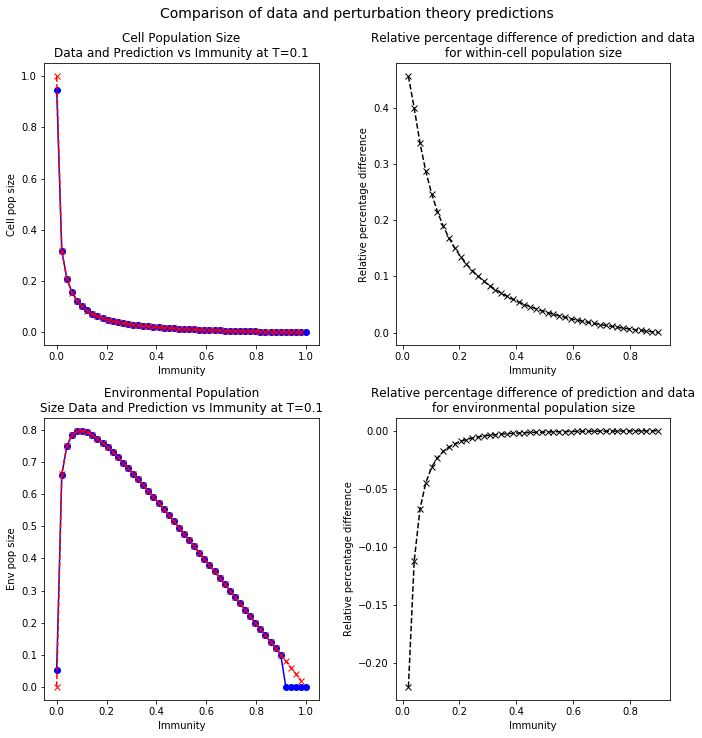

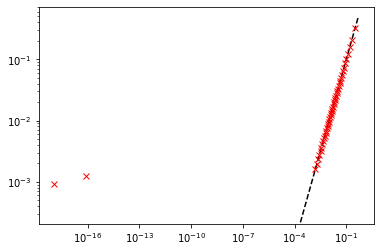

In [16]:
# cell pop size for T=0.1 from simulation
res_cell_t01 = np.array([ 9.46280122e-01,  3.19345444e-01,  2.10027292e-01,  1.56138808e-01,
        1.23480476e-01,  1.01441637e-01,  8.55255276e-02,  7.34756514e-02,
        6.40285909e-02,  5.64196333e-02,  5.01579568e-02,  4.49137464e-02,
        4.04569916e-02,  3.66223045e-02,  3.32876854e-02,  3.03611271e-02,
        2.77719274e-02,  2.54648477e-02,  2.33961027e-02,  2.15305313e-02,
        1.98395718e-02,  1.82997826e-02,  1.68917403e-02,  1.55992145e-02,
        1.44085418e-02,  1.33081293e-02,  1.22880815e-02,  1.13399010e-02,
        1.04562454e-02,  9.63074155e-03,  8.85782950e-03,  8.13263655e-03,
        7.45087303e-03,  6.80875033e-03,  6.20290684e-03,  5.63035160e-03,
        5.08841313e-03,  4.57469886e-03,  4.08705929e-03,  3.62355751e-03,
        3.18244426e-03,  2.76213512e-03,  2.36119214e-03,  1.97830633e-03,
        1.61228434e-03,  8.06960943e-17,  1.13858527e-18, 0.0,
       0.0, 0.0])

# env pop size for T=0.1 from simulation
res_env_t01 = np.array([1.0743982e+03, 1.3204928e+04, 1.4983128e+04, 1.5652734e+04,
       1.5897737e+04, 1.5930351e+04, 1.5840510e+04, 1.5673344e+04,
       1.5454122e+04, 1.5198138e+04, 1.4915208e+04, 1.4611929e+04,
       1.4292901e+04, 1.3961432e+04, 1.3619961e+04, 1.3270328e+04,
       1.2913949e+04, 1.2551928e+04, 1.2185139e+04, 1.1814287e+04,
       1.1439943e+04, 1.1062576e+04, 1.0682573e+04, 1.0300261e+04,
       9.9159111e+03, 9.5297559e+03, 9.1419932e+03, 8.7527939e+03,
       8.3623037e+03, 7.9706504e+03, 7.5779453e+03, 7.1842861e+03,
       6.7897578e+03, 6.3944370e+03, 5.9983906e+03, 5.6016787e+03,
       5.2043540e+03, 4.8064653e+03, 4.4080547e+03, 4.0091616e+03,
       3.6098206e+03, 3.2100635e+03, 2.8099189e+03, 2.4094136e+03,
       2.0085707e+03, 5.2000002e-11, 1.0000000e-12, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00])/20000

pred_t01 = (1 - np.linspace(0,1,50)) * (1 - root_minus - gamma * ((1 - root_minus) ** 2))

plt.close()
fig, axs = plt.subplots(2,2,sharex=False, sharey=False, figsize=(10,10))
# plt.plot(np.arange(1,10)/10., [np.sum(_[-1][-1]) for _ in perturb_res_01k_lowa[:-1]], 'bo--')
axs[0,0].plot(np.linspace(0,1,50), res_cell_t01,
         'bo-', label='Data')
axs[0,0].plot(np.linspace(0,1,50), root_minus,
         'rx--', label='Prediction')
axs[0,0].set_title('Cell Population Size\nData and Prediction vs Immunity at T=0.1')
axs[0,0].set_ylabel('Cell pop size')
axs[0,0].set_xlabel('Immunity')

axs[0,1].plot(np.linspace(0,1,50)[1:-5], 100*(res_cell_t01[1:-5] - root_minus[1:-5]) / res_cell_t01[1:-5], 'kx--')
axs[0,1].set_xlabel('Immunity')
axs[0,1].set_ylabel('Relative percentage difference')
axs[0,1].set_title('Relative percentage difference of prediction and data\nfor within-cell population size')

axs[1,0].plot(np.linspace(0,1,50), res_env_t01,
         'bo-', label='Data')
axs[1,0].plot(np.linspace(0,1,50), 
         pred_t01,
         'rx--', label='Prediction')
axs[1,0].set_title('Environmental Population\nSize Data and Prediction vs Immunity at T=0.1')
axs[1,0].set_ylabel('Env pop size')
axs[1,0].set_xlabel('Immunity')

axs[1,1].plot(np.linspace(0,1,50)[1:-5], 100*(res_env_t01[1:-5] - pred_t01[1:-5]) / res_env_t01[1:-5], 'kx--')
axs[1,1].set_xlabel('Immunity')
axs[1,1].set_ylabel('Relative percentage difference')
axs[1,1].set_title('Relative percentage difference of prediction and data\nfor environmental population size')
plt.tight_layout()
plt.suptitle('Comparison of data and perturbation theory predictions', size=14, y=1.02)
plt.show()
plt.close()

plt.close()
plt.figure()
plt.plot([0,.5], [0,0.5], 'k--')
plt.plot(res_cell_t01[1:], root_minus[1:], 'rx')
plt.loglog()
plt.show()
plt.close()